#### Description: 
- This process creates a trend line (robust to outliers) for the time series, considers points 3+ SD away from the trend line as an outlier and calculated the rend of the last 6 months in a way that considers noise and seasonality.
- Previous versions compared average 6 mo rate to the historical average and calculated the percent change between these 2 numbers
    - Pros: Quick and dirty, easy to explain to a non-technical audience
    - Cons: Average is affected by outliers meaning the result may not be a good reflection of the underlying trend of the data. Additionally, if years 2017-2020 were really high and then decreased in more recent years (or vice versa), the average still may indicate a high historical average without considering the downward trend of more recent years. Thus, when compared to 6 mo trend, it may calculate an upward trend as a downward trend.


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [41]:
df = pd.DataFrame()

In [42]:
df = pd.read_csv('outlier_uptrend_detection_input.csv')

In [43]:
df['monthyear_dt'] = pd.to_datetime(df['monthyear'])
df['ordinal_time'] = df['monthyear_dt'].map(pd.Timestamp.toordinal)

In [44]:
recent_date = pd.to_datetime('2024-10-01').toordinal()

----------------------------------------

Category : 1



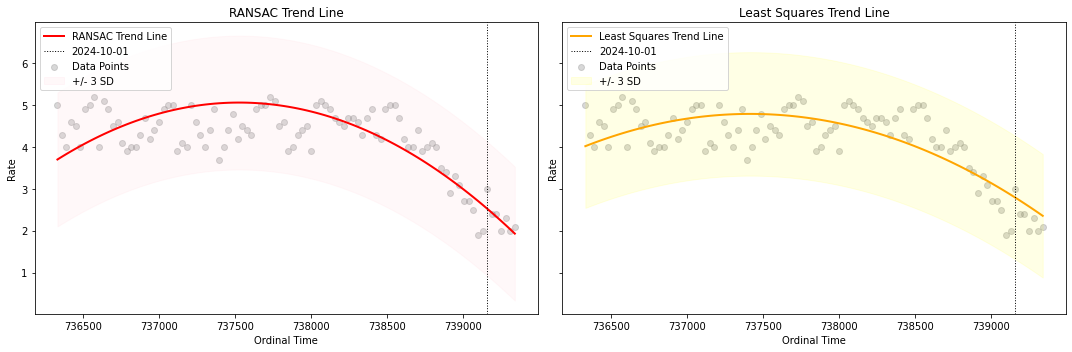

----------------------------------------

Category : 2

** RECENT OUTLIERS PRESENT **

Outliers:
 monthyear  rate  y_upper  y_lower
2025-01-01  17.0 8.844612 0.087717

** RECENT UPTREND PRESENT **



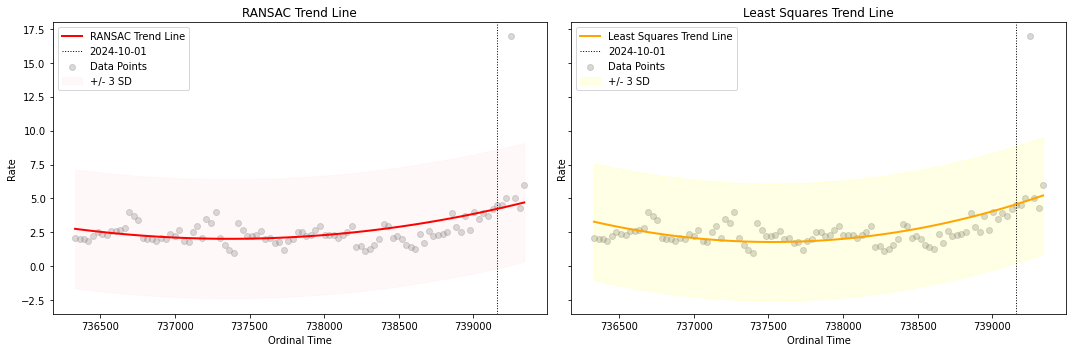

----------------------------------------

Category : 3



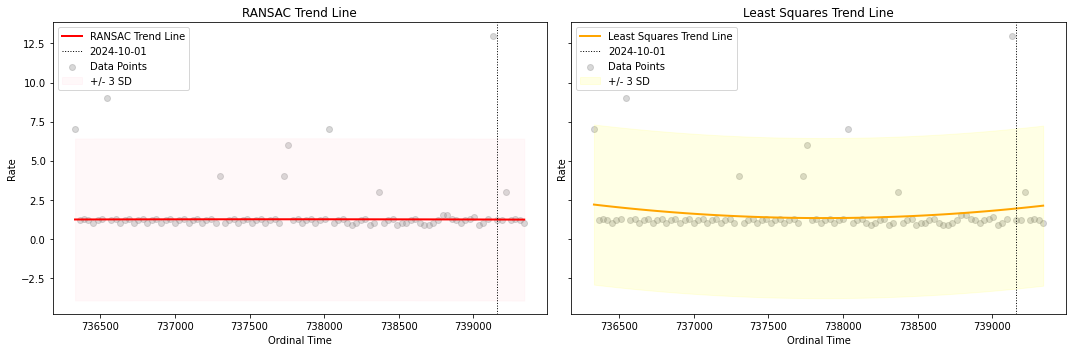

In [46]:
for category_to_plot in df['category_id'].unique():
    
    df_category = df[df['category_id'] == category_to_plot].copy()
    df_category = df_category.sort_values(by='monthyear')
    
    x = df_category['ordinal_time'].values
    x_date = df_category['monthyear']
    y = df_category['rate'].values
    
    if len(x) < 10: # If there is not a sufficient amount of data, then skip
        continue
        
        
    # LEAST SQUARES TREND LINE
    coefficients = np.polyfit(x, y, 2)
    ls_model = np.poly1d(coefficients)
    ls_y = ls_model(x)
    
    ls_residuals = y - ls_y
    ls_std = ls_residuals.std()
    ls_y_upper = ls_y + (3 * ls_std)
    ls_y_lower = ls_y - (3 * ls_std)
    
    # RANSAC TREND LINE
    x_reshaped = x.reshape(-1, 1)
    ransac_model = Pipeline(steps=[('poly', PolynomialFeatures(degree=2)), ('ransac', RANSACRegressor(random_state=42))])
    ransac_model.fit(x_reshaped, y)
    ransac_y = ransac_model.predict(x_reshaped)
    
    ransac_residuals = y - ransac_y
    ransac_std = ransac_residuals.std()
    ransac_y_upper = ransac_y + (3 * ransac_std)
    ransac_y_lower = ransac_y - (3 * ransac_std)
    
    
    # RECENT TREND CHECK
    ransac_trend_df = pd.DataFrame({'monthyear': x_date, 'ordinal_time': x, 'rate': y, 'y_trend': ransac_y, 'y_upper': ransac_y_upper, 'y_lower': ransac_y_lower})
    recent_ransac_trend_df = ransac_trend_df[ransac_trend_df['ordinal_time'] > recent_date]
    slope_rise = -1
    if recent_ransac_trend_df.shape[0] >= 2:
        y1 = recent_ransac_trend_df['y_trend'].iloc[0]
        y2 = recent_ransac_trend_df['y_trend'].iloc[-1]
        slope_rise = y2 - y1
        
    # OUTLIER DETECTION
    recent_ransac_trend_df = ransac_trend_df[ransac_trend_df['ordinal_time'] > recent_date].copy()
    recent_ransac_trend_df['is_outlier'] = ((recent_ransac_trend_df['rate'] > recent_ransac_trend_df['y_upper']) | (recent_ransac_trend_df['rate'] < recent_ransac_trend_df['y_lower']))
    outliers = recent_ransac_trend_df[recent_ransac_trend_df['is_outlier']]
    
    # PLOT IF RECENT UPTREND OR RECENT OUTLIER
    print("-" * 40 + "\n")
    print(f"Category : {category_to_plot}\n")
    if (not outliers.empty):
        print("** RECENT OUTLIERS PRESENT **\n")
        print("Outliers:")
        print(outliers[['monthyear', 'rate', 'y_upper', 'y_lower']].to_string(index=False)+"\n")
    if (slope_rise > 0):
        print("** RECENT UPTREND PRESENT **\n")
        
    fig, axs = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(15, 5)
        
    # LEAST SQUARES TREND LINE PLOT
    axs[0].scatter(x, y, label='Data Points', alpha=0.3, color='gray')
    axs[0].plot(x, ransac_y, color='red', linewidth=2, label = 'RANSAC Trend Line')
    axs[0].fill_between(x, ransac_y_lower, ransac_y_upper, color='pink', alpha=0.1, label='+/- 3 SD')
    axs[0].axvline(x = recent_date, color='black', linestyle=':', linewidth=1, label='2024-10-01')
    axs[0].set_title('RANSAC Trend Line')
    axs[0].set_xlabel('Ordinal Time')
    axs[0].set_ylabel('Rate')
    axs[0].legend()
        
    # RANSAC TREND LINE PLOT
    axs[1].scatter(x, y, label='Data Points', alpha=0.3, color='gray')
    axs[1].plot(x, ls_y, color='orange', linewidth=2, label = 'Least Squares Trend Line')
    axs[1].fill_between(x, ls_y_lower, ls_y_upper, color='yellow', alpha=0.1, label='+/- 3 SD')
    axs[1].axvline(x = recent_date, color='black', linestyle=':', linewidth=1, label='2024-10-01')
    axs[1].set_title('Least Squares Trend Line')
    axs[1].set_xlabel('Ordinal Time')
    axs[1].set_ylabel('Rate')
    axs[1].legend()
        
    plt.tight_layout()
    plt.show()